In [2]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
#import pingouin as pg
#import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 30 seconds


In [3]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [4]:
# Load file (from same directory as the notebook)
DATA = pd.read_excel(os.path.expanduser("natrepCOVID.xlsx"))
DATA.head()

,Partnum,cond,political,CHANGE_Fbaseline,CHANGE_Cbaseline,CHANGE_F,CHANGE_C,change_k,CHANGE_Kbaseline,Age,Gender,votereg,Resist,Trump,Edu,Partystr
0,1,1,1.0,-25.00,-24.00,-25.00,-24.00,-1.00,-1.00,54,1,1,3.333333,1,4,3
1,2,1,1.0,0.50,-6.75,0.50,-6.75,7.25,7.25,57,0,0,2.333333,2,3,3
2,3,1,1.0,-1.25,-5.00,-1.25,-5.00,3.75,3.75,31,1,1,3.333333,3,3,3
3,4,1,2.0,0.00,-6.25,0.00,-6.25,6.25,6.25,24,1,1,5.000000,6,2,5
4,5,1,2.0,7.50,-14.75,7.50,-14.75,22.25,22.25,40,1,1,4.000000,6,2,3


In [5]:
DATA_1 = DATA.loc[DATA["cond"]==1]
DATA_2 = DATA.loc[DATA["cond"]==2]
DATA_3 = DATA.loc[DATA["cond"]==3]
DATA_4 = DATA.loc[DATA["cond"]==4]
DATA_5 = DATA.loc[DATA["cond"]==5]
DATA_6 = DATA.loc[DATA["cond"]==6]
DATA_7 = DATA.loc[DATA["cond"]==7]
DATA_8 = DATA.loc[DATA["cond"]==8]
DATA_9 = DATA.loc[DATA["cond"]==9]
DATA_10 = DATA.loc[DATA["cond"]==10]

<IPython.core.display.Javascript object>


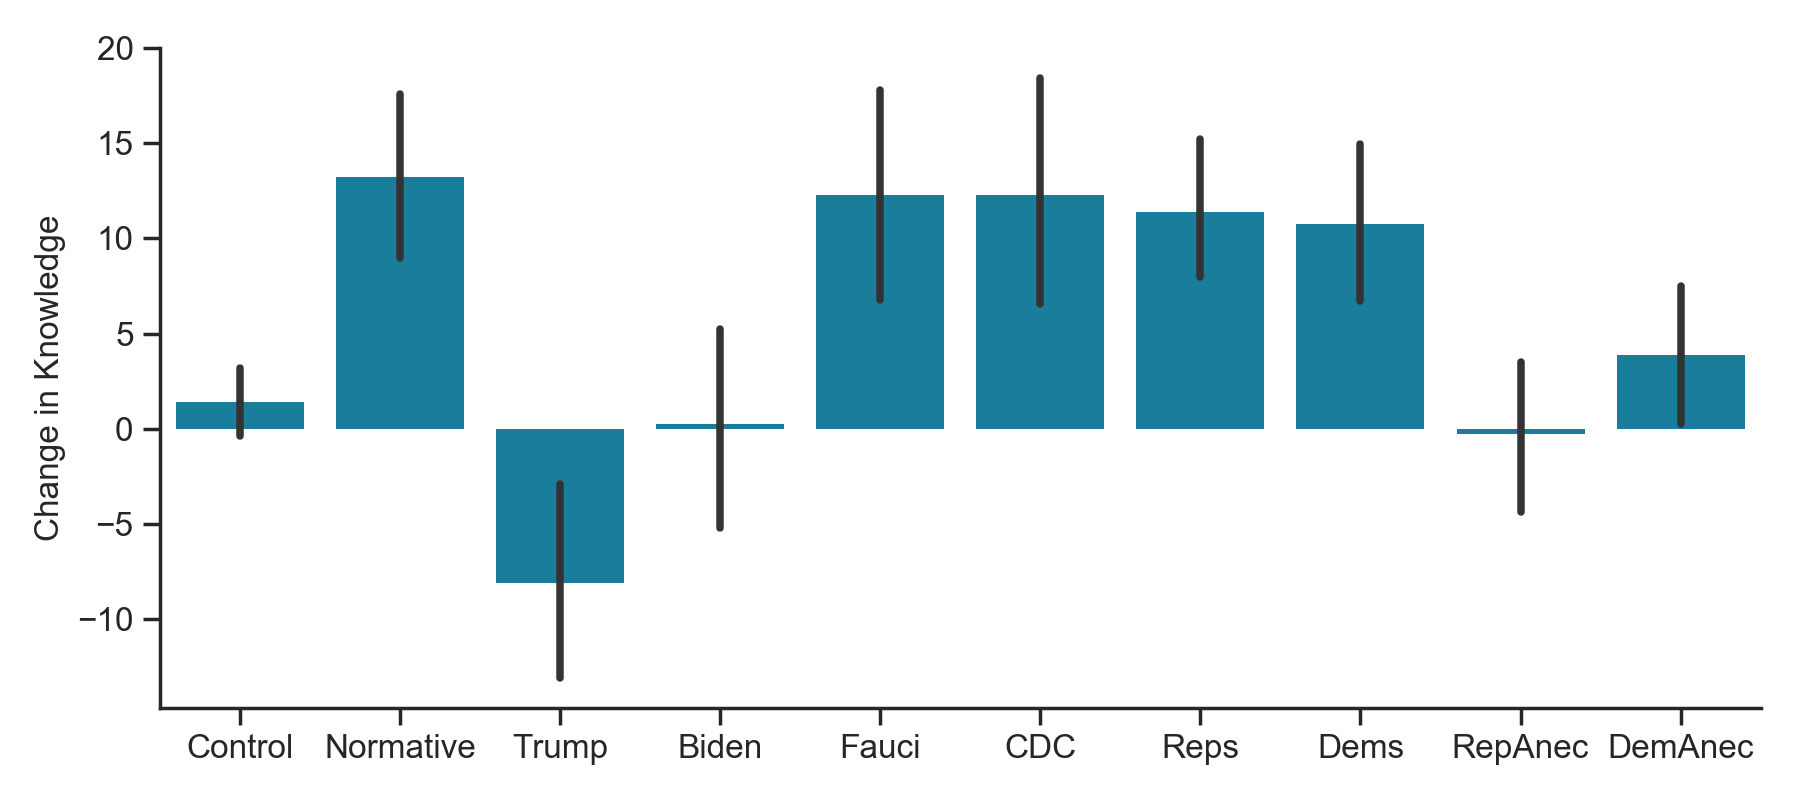

In [7]:
pal = ["#0489B1"]

fig, ax = plt.subplots(1,1, figsize=(9,4))
sns.barplot(x=DATA.cond, y=DATA.change_k, data=DATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax)
sns.despine()
ax.set_xticklabels(["Control","Normative", "Trump", "Biden", "Fauci", "CDC", "Reps", "Dems", "RepAnec","DemAnec"])
ax.set_ylabel("Change in Knowledge")
ax.set_xlabel("")

plt.tight_layout()

<IPython.core.display.Javascript object>


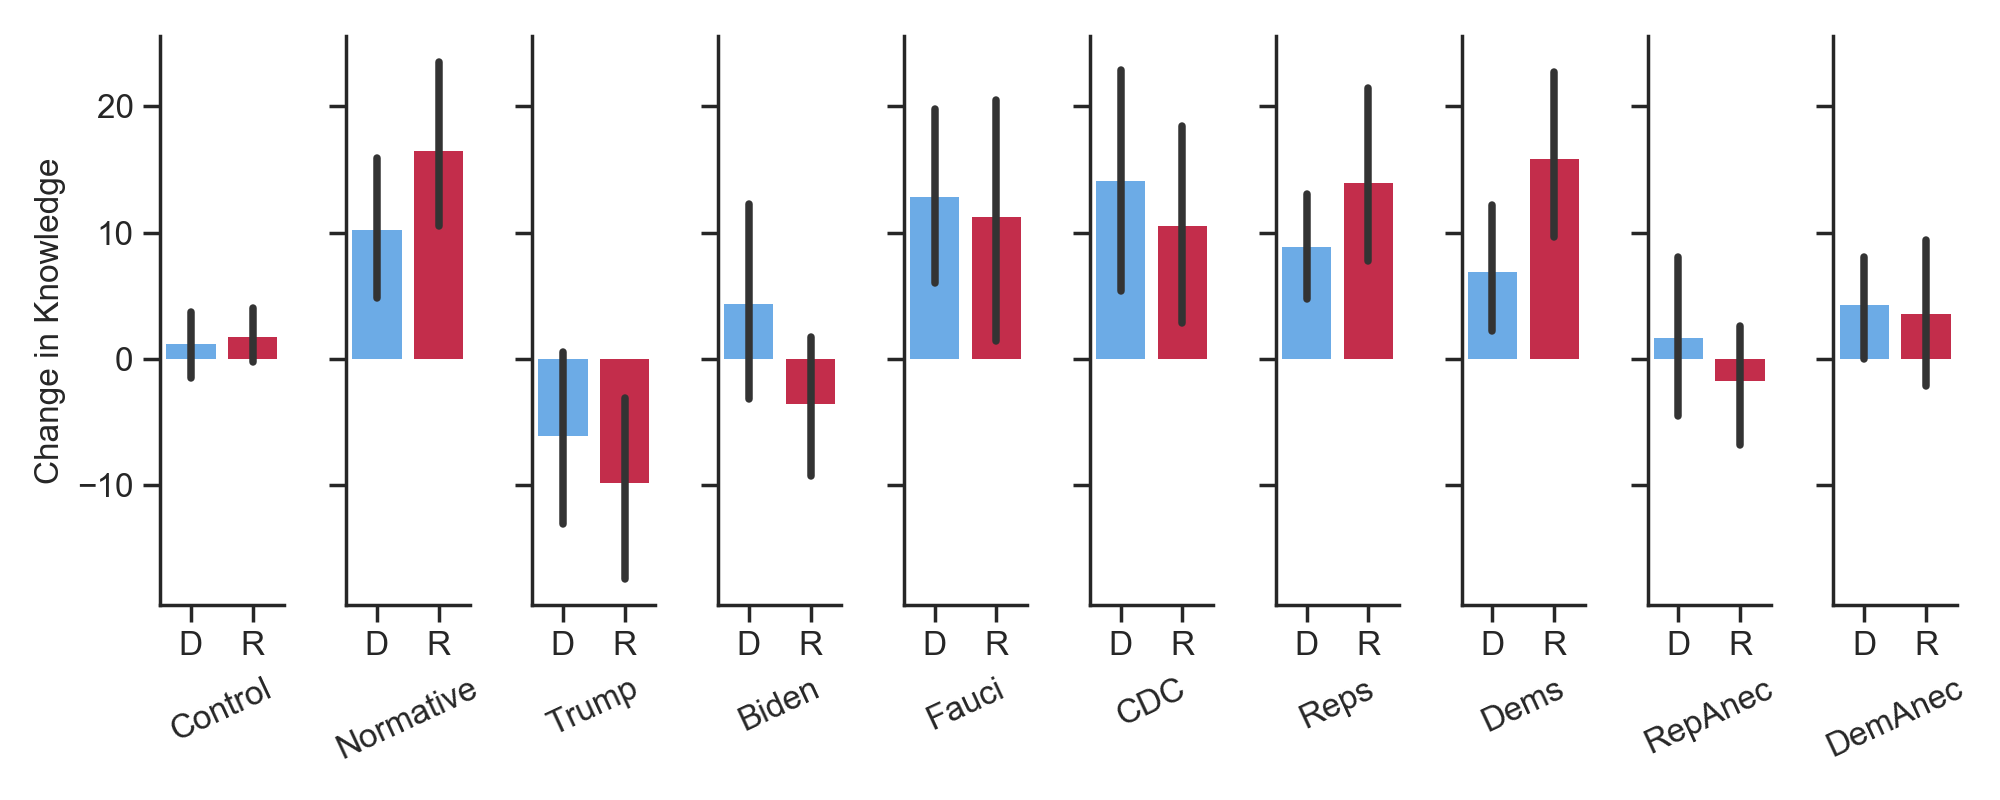

In [8]:
pall = ["#58ACFA", "#DC143C"]

fig, ax = plt.subplots(1,10, figsize=(10,4), sharey=True)

sns.barplot(x=DATA_1.political, y=DATA_1.CHANGE_Kbaseline, data=DATA_1, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.despine()
ax[0].set_xlabel("Control", rotation=25)
ax[0].set_xticklabels(["D", "R"])
ax[0].set_ylabel("Change in Knowledge")

sns.barplot(x=DATA_2.political, y=DATA_2.change_k, data=DATA_2, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
sns.despine()
ax[1].set_xlabel("Normative", rotation=25)
ax[1].set_xticklabels(["D", "R"])
ax[1].set_ylabel("")

sns.barplot(x=DATA_3.political, y=DATA_3.change_k, data=DATA_3, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
sns.despine()
ax[2].set_xlabel("Trump", rotation=25)
ax[2].set_xticklabels(["D", "R"])
ax[2].set_ylabel("")

sns.barplot(x=DATA_4.political, y=DATA_4.change_k, data=DATA_4, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3])
sns.despine()
ax[3].set_xlabel("Biden", rotation=25)
ax[3].set_xticklabels(["D", "R"])
ax[3].set_ylabel("")

sns.barplot(x=DATA_5.political, y=DATA_5.change_k, data=DATA_5, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[4])
sns.despine()
ax[4].set_xlabel("Fauci", rotation=25)
ax[4].set_xticklabels(["D", "R"])
ax[4].set_ylabel("")

sns.barplot(x=DATA_6.political, y=DATA_6.change_k, data=DATA_6, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[5])
sns.despine()
ax[5].set_xlabel("CDC", rotation=25)
ax[5].set_xticklabels(["D", "R"])
ax[5].set_ylabel("")

sns.barplot(x=DATA_7.political, y=DATA_7.change_k, data=DATA_7, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[6])
sns.despine()
ax[6].set_xlabel("Reps", rotation=25)
ax[6].set_xticklabels(["D", "R"])
ax[6].set_ylabel("")

sns.barplot(x=DATA_8.political, y=DATA_8.change_k, data=DATA_8, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[7])
sns.despine()
ax[7].set_xlabel("Dems", rotation=25)
ax[7].set_xticklabels(["D", "R"])
ax[7].set_ylabel("")

sns.barplot(x=DATA_9.political, y=DATA_9.change_k, data=DATA_9, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[8])
sns.despine()
ax[8].set_xlabel("RepAnec", rotation=25)
ax[8].set_xticklabels(["D", "R"])
ax[8].set_ylabel("")

sns.barplot(x=DATA_10.political, y=DATA_10.change_k, data=DATA_10, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[9])
sns.despine()
ax[9].set_xlabel("DemAnec", rotation=25)
ax[9].set_xticklabels(["D", "R"])
ax[9].set_ylabel("")

plt.tight_layout()

<IPython.core.display.Javascript object>


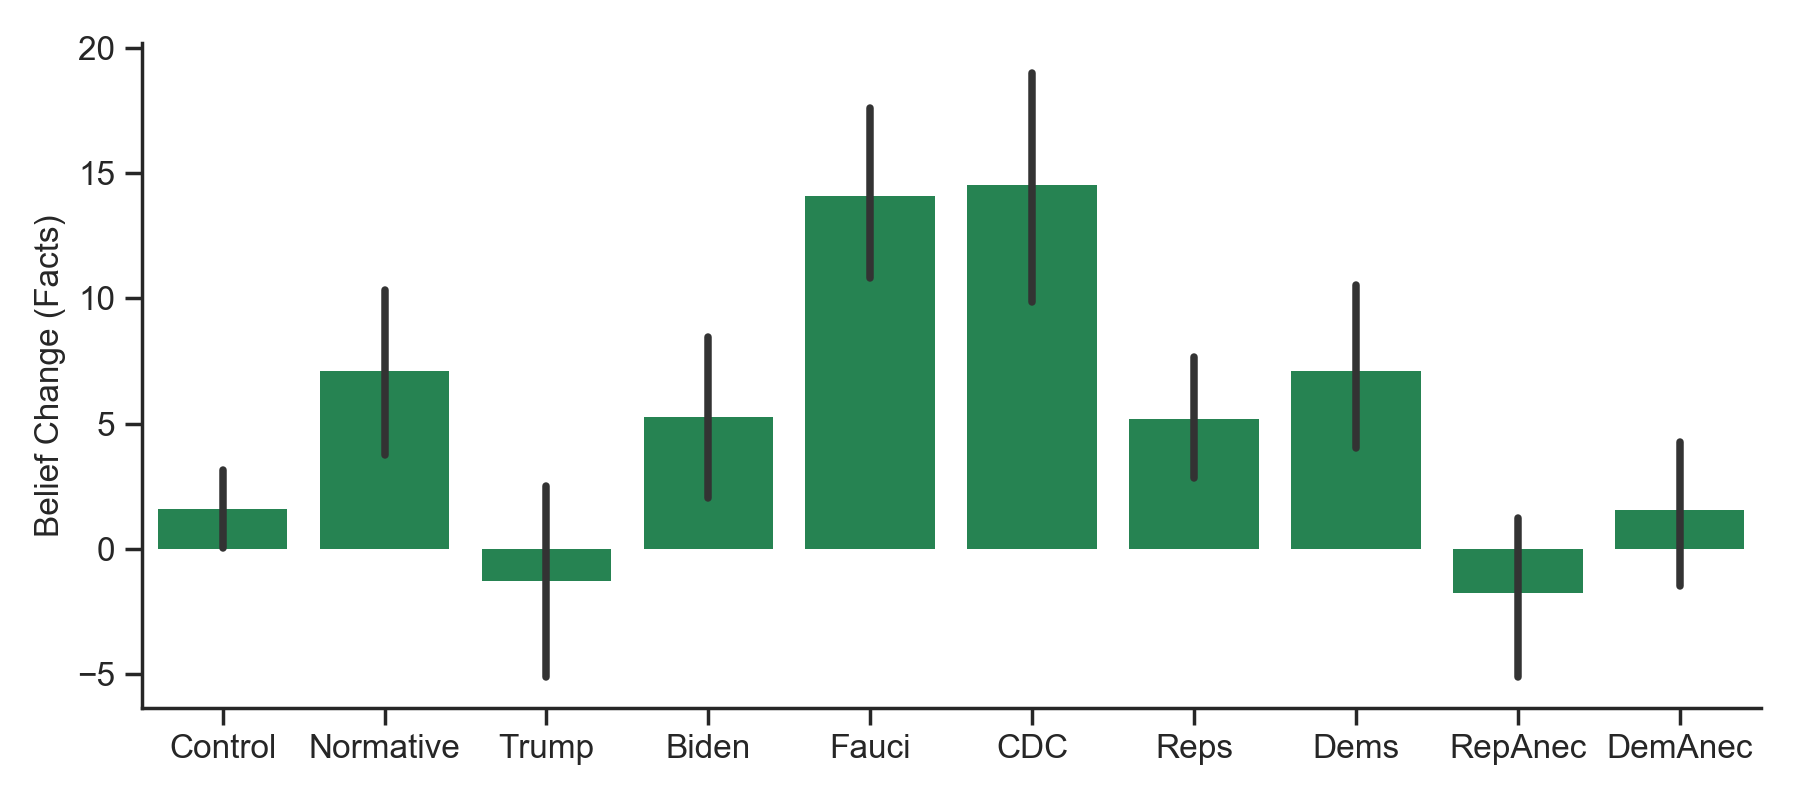

In [9]:
pal = ["#169351"]

fig, ax = plt.subplots(1,1, figsize=(9,4))
sns.barplot(x=DATA.cond, y=DATA.CHANGE_F, data=DATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax)
sns.despine()
ax.set_xticklabels(["Control","Normative", "Trump", "Biden", "Fauci", "CDC", "Reps", "Dems", "RepAnec","DemAnec"])
ax.set_ylabel("Belief Change (Facts)")
ax.set_xlabel("")

plt.tight_layout()

<IPython.core.display.Javascript object>


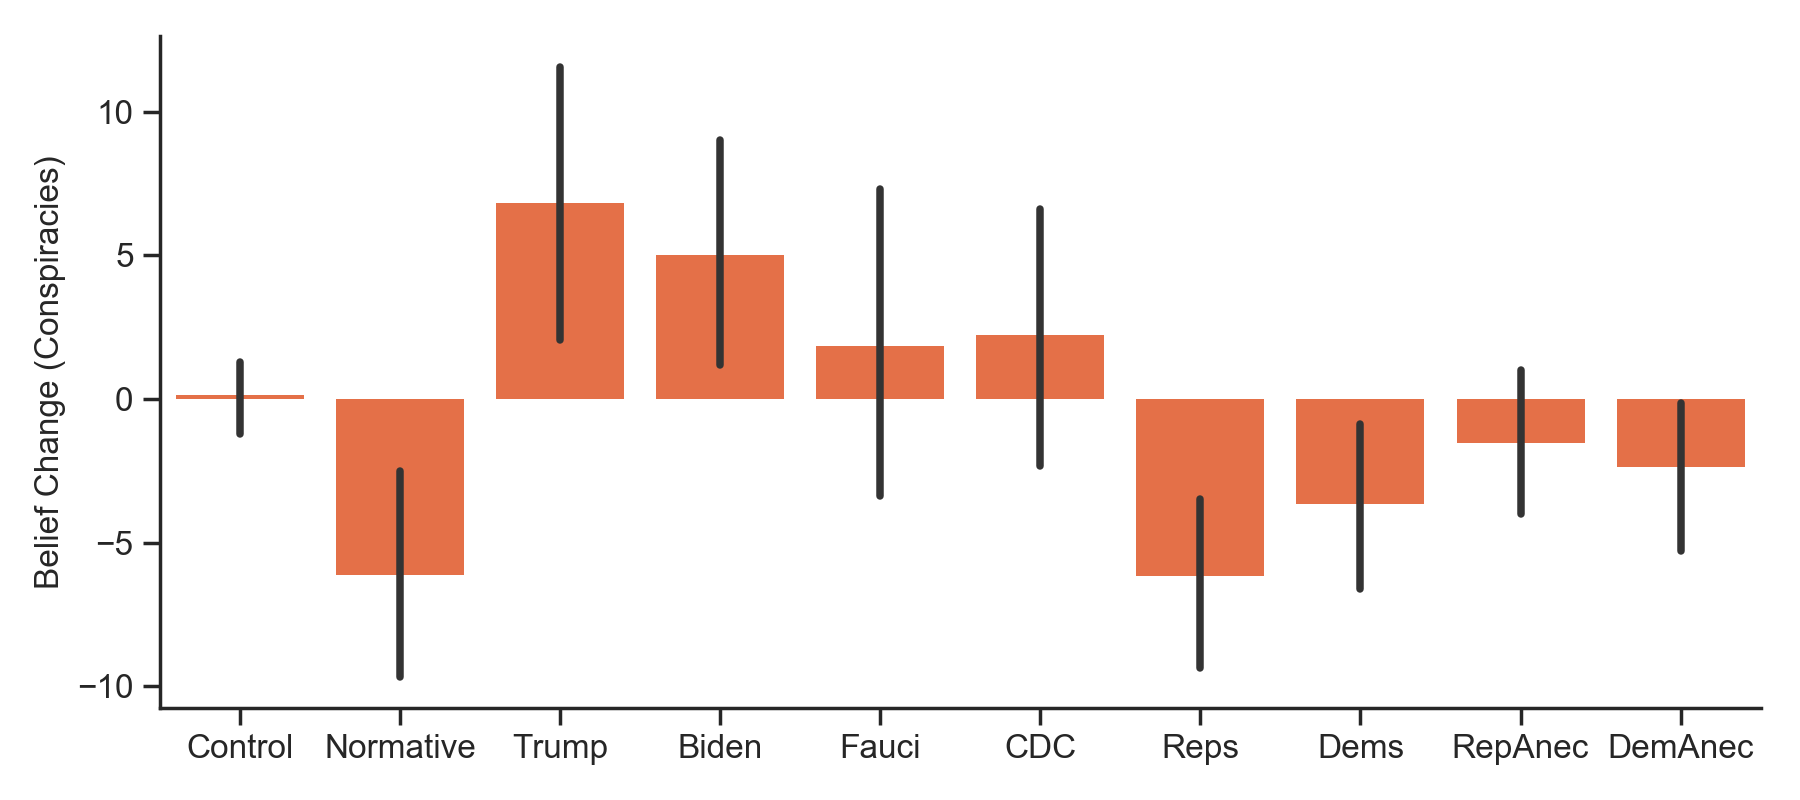

In [10]:
pal = ["#FE642E"]

fig, ax = plt.subplots(1,1, figsize=(9,4))
sns.barplot(x=DATA.cond, y=DATA.CHANGE_C, data=DATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax)
sns.despine()
ax.set_xticklabels(["Control","Normative", "Trump", "Biden", "Fauci", "CDC", "Reps", "Dems", "RepAnec","DemAnec"])
ax.set_ylabel("Belief Change (Conspiracies)")
ax.set_xlabel("")

plt.tight_layout()

<IPython.core.display.Javascript object>


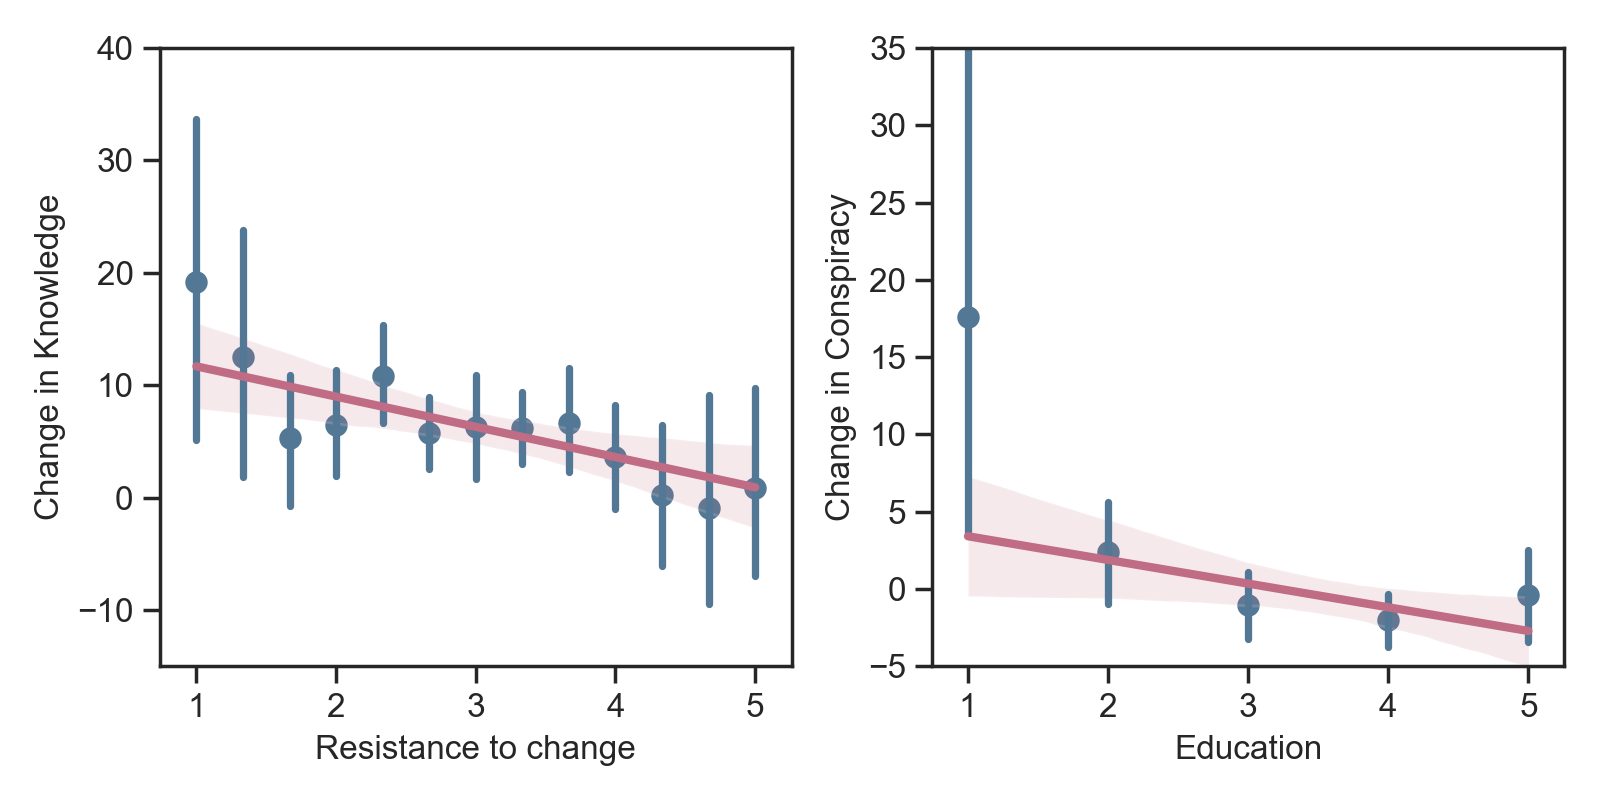

[Text(0.5, 33.0, 'Education')]

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.regplot(x=DATA.Resist, y=DATA.change_k, scatter_kws={"color": "#537895"}, \
            line_kws={"color":"#C06C84","alpha":1,"lw":3}, x_estimator=np.mean, ax=ax[0])
plt.tight_layout()
ax[0].set_ylim([-15,40])
ax[0].set_ylabel('Change in Knowledge')
ax[0].set(xlabel='Resistance to change')



sns.regplot(x=DATA.Edu, y=DATA.CHANGE_C, scatter_kws={"color": "#537895"}, \
            line_kws={"color":"#C06C84","alpha":1,"lw":3}, x_estimator=np.mean, ax=ax[1])
plt.tight_layout()
ax[1].set_ylim([-5,35])
ax[1].set_ylabel('Change in Conspiracy')
ax[1].set(xlabel='Education')

In [13]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
# %R library(lme4)

%R library(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [14]:
%Rpush DATA

In [16]:
%%R

M <- lm(change_k ~ as.factor(political) + Age + as.factor(Gender) + Resist + Trump + Edu + Partystr, data = DATA)
print(summary(M))


Call:
lm(formula = change_k ~ as.factor(political) + Age + as.factor(Gender) + 
    Resist + Trump + Edu + Partystr, data = DATA)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.600  -10.140   -2.487    9.044  103.517 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)   
(Intercept)              5.75122    5.15894   1.115  0.26519   
as.factor(political)2   -0.43654    2.31314  -0.189  0.85035   
as.factor(political)NaN 21.62951   17.19340   1.258  0.20867   
Age                      0.02268    0.04491   0.505  0.61368   
as.factor(Gender)1       2.06142    1.52564   1.351  0.17693   
Resist                  -2.67389    0.87821  -3.045  0.00239 **
Trump                    0.28076    0.50583   0.555  0.57898   
Edu                      1.19859    0.75665   1.584  0.11348   
Partystr                 0.33137    0.74565   0.444  0.65684   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.21 on 1051 deg

In [17]:
%%R

M <- lm(CHANGE_F ~ as.factor(political) + Age + as.factor(Gender) + Resist + Trump + Edu + Partystr, data = DATA)
print(summary(M))


Call:
lm(formula = CHANGE_F ~ as.factor(political) + Age + as.factor(Gender) + 
    Resist + Trump + Edu + Partystr, data = DATA)

Residuals:
     Min       1Q   Median       3Q      Max 
-104.250   -7.273   -2.644    5.738   90.640 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)  
(Intercept)              9.59134    3.81900   2.511   0.0122 *
as.factor(political)2    1.56487    1.71234   0.914   0.3610  
as.factor(political)NaN 10.35498   12.72772   0.814   0.4161  
Age                      0.01835    0.03325   0.552   0.5810  
as.factor(Gender)1       1.77684    1.12939   1.573   0.1160  
Resist                  -1.57266    0.65011  -2.419   0.0157 *
Trump                   -0.10342    0.37445  -0.276   0.7825  
Edu                     -0.19156    0.56013  -0.342   0.7324  
Partystr                -0.24150    0.55198  -0.438   0.6618  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.92 on 1051 degrees of fr

In [18]:
%%R

M <- lm(CHANGE_C ~ as.factor(political) + Age + as.factor(Gender) + Resist + Trump + Edu + Partystr, data = DATA)
print(summary(M))


Call:
lm(formula = CHANGE_C ~ as.factor(political) + Age + as.factor(Gender) + 
    Resist + Trump + Edu + Partystr, data = DATA)

Residuals:
    Min      1Q  Median      3Q     Max 
-97.449  -5.131   0.285   3.990  97.099 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)  
(Intercept)               3.840122   4.142261   0.927   0.3541  
as.factor(political)2     2.001412   1.857284   1.078   0.2815  
as.factor(political)NaN -11.274528  13.805079  -0.817   0.4143  
Age                      -0.004326   0.036063  -0.120   0.9045  
as.factor(Gender)1       -0.284578   1.224984  -0.232   0.8163  
Resist                    1.101231   0.705139   1.562   0.1187  
Trump                    -0.384173   0.406143  -0.946   0.3444  
Edu                      -1.390146   0.607539  -2.288   0.0223 *
Partystr                 -0.572867   0.598707  -0.957   0.3389  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.43 on 1051 deg

In [19]:
# Load file (from same directory as the notebook)
DAT = pd.read_excel(os.path.expanduser("Book3.xlsx"))
DAT.head()

,Partnum,cond,political,Age,Gender,votereg,Resist,Trump,Edu,Partystr,CHANGE_F,CHANGE_C,change_k,baseline
0,1,1,1.0,54,1,1,3.333333,1,4,3,-25.00,-24.00,-1.00,0
1,2,1,1.0,57,0,0,2.333333,2,3,3,0.50,-6.75,7.25,0
2,3,1,1.0,31,1,1,3.333333,3,3,3,-1.25,-5.00,3.75,0
3,4,1,2.0,24,1,1,5.000000,6,2,5,0.00,-6.25,6.25,0
4,5,1,2.0,40,1,1,4.000000,6,2,3,7.50,-14.75,22.25,0


In [20]:
DAT_1 = DAT.loc[DAT["cond"]==1]
DAT_2 = DAT.loc[DAT["cond"]==2]
DAT_3 = DAT.loc[DAT["cond"]==3]
DAT_4 = DAT.loc[DAT["cond"]==4]
DAT_5 = DAT.loc[DAT["cond"]==5]
DAT_6 = DAT.loc[DAT["cond"]==6]
DAT_7 = DAT.loc[DAT["cond"]==7]
DAT_8 = DAT.loc[DAT["cond"]==8]
DAT_9 = DAT.loc[DAT["cond"]==9]
DAT_10 = DAT.loc[DAT["cond"]==10]

<IPython.core.display.Javascript object>


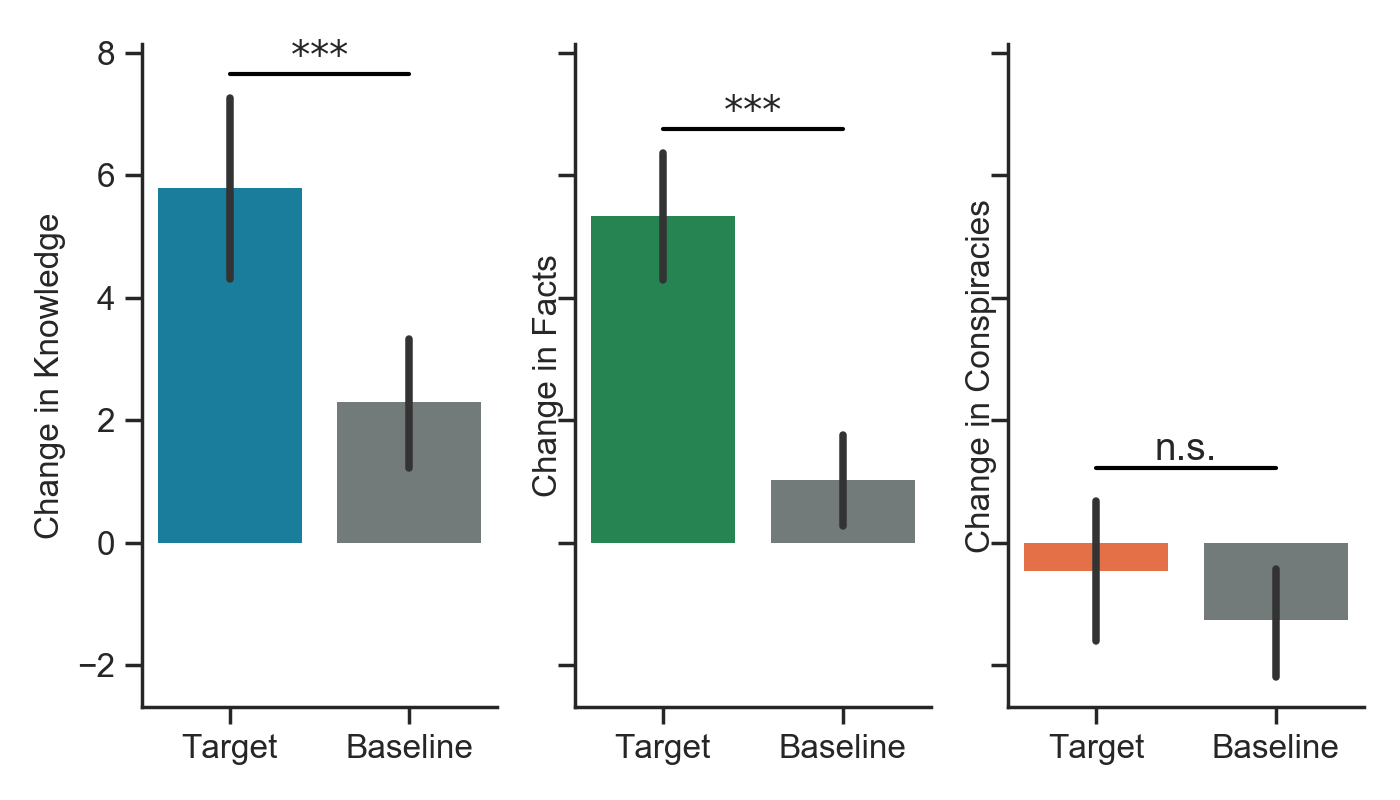

In [21]:
pal1 = ["#0489B1", "#707B7C"]
pal2 = ["#169351", "#707B7C"]
pal3 = ["#FE642E", "#707B7C"]


fig, ax = plt.subplots(1,3, figsize=(7,4), sharey=True)
sns.barplot(x=DAT.baseline, y=DAT.change_k, data=DAT, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.despine()
ax[0].set_xticklabels(["Target","Baseline"])
ax[0].set_ylabel("Change in Knowledge")
ax[0].set_xlabel("")
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(DAT.loc[DAT.baseline==1, "change_k"], \
                       DAT.loc[DAT.baseline==0, "change_k"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=DAT.baseline, y=DAT.CHANGE_F, data=DAT, \
            palette=pal2, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
sns.despine()
ax[1].set_xticklabels(["Target","Baseline"])
ax[1].set_ylabel("Change in Facts")
ax[1].set_xlabel("")
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(DAT.loc[DAT.baseline==1, "CHANGE_F"], \
                       DAT.loc[DAT.baseline==0, "CHANGE_F"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=DAT.baseline, y=DAT.CHANGE_C, data=DAT, \
            palette=pal3, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
sns.despine()
ax[2].set_xticklabels(["Target","Baseline"])
ax[2].set_ylabel("Change in Conspiracies")
ax[2].set_xlabel("")
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_ind(DAT.loc[DAT.baseline==1, "CHANGE_C"], \
                       DAT.loc[DAT.baseline==0, "CHANGE_C"])
bff.barplot_annotate_brackets(ax[2], 0, 1, p, datahandles, dh=0.05, fs=14)

plt.tight_layout()

<IPython.core.display.Javascript object>


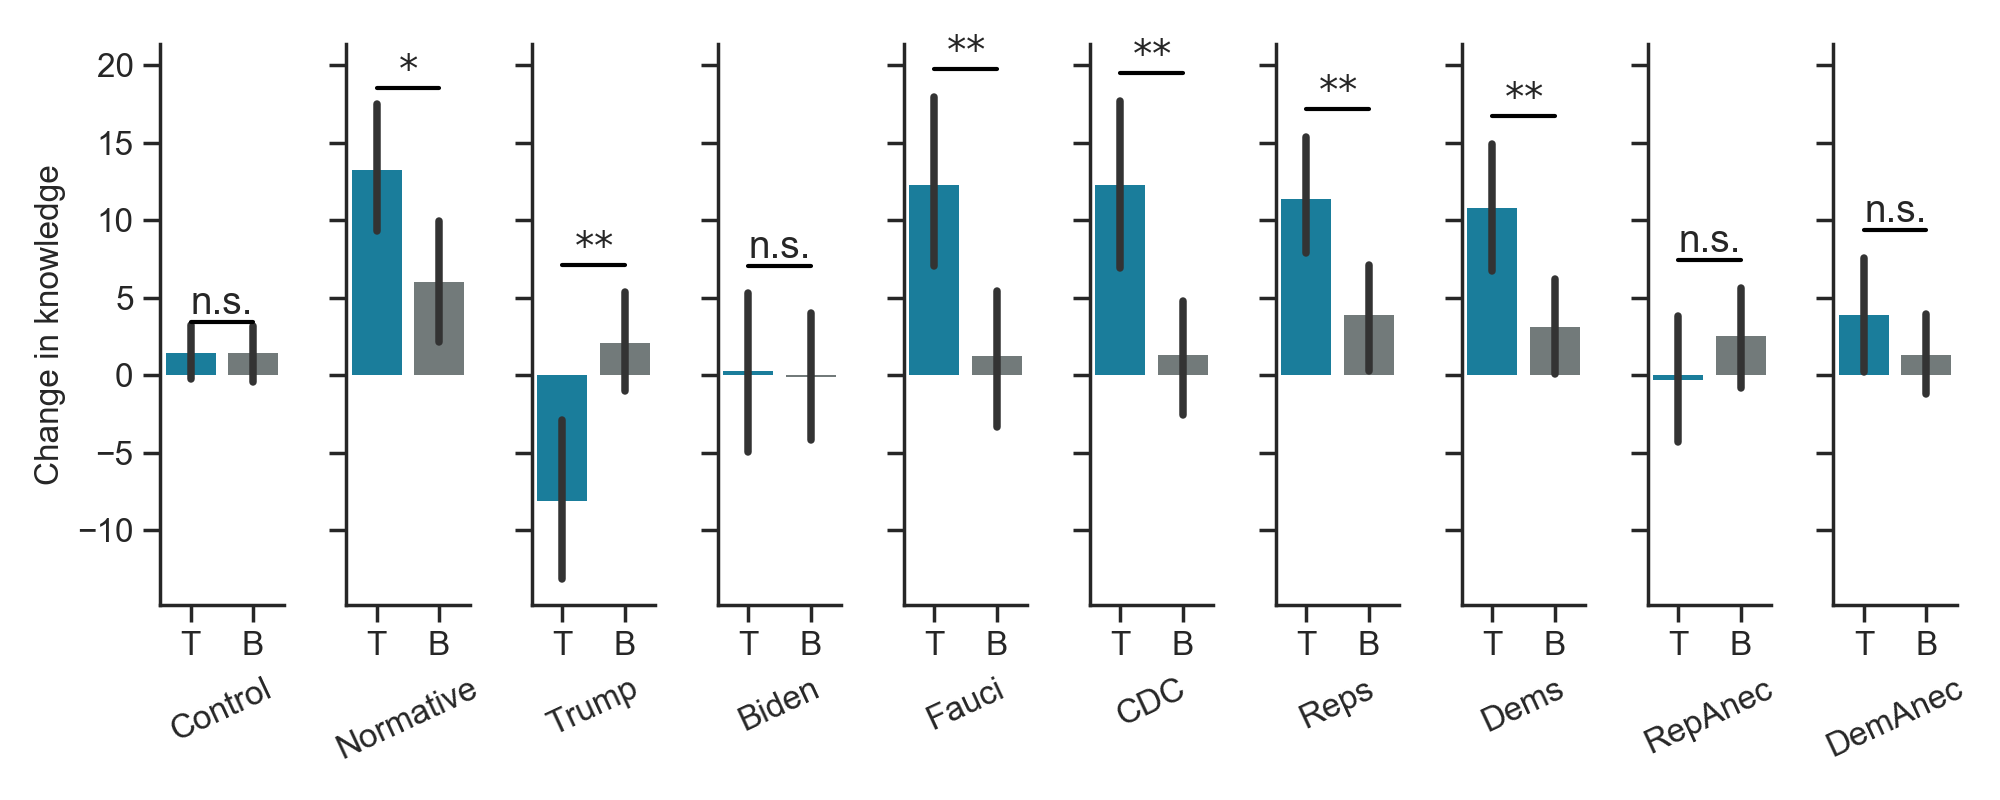

In [28]:
pall = ["#0489B1", "#707B7C"]

fig, ax = plt.subplots(1,10, figsize=(10,4), sharey=True)

sns.barplot(x=DAT_1.baseline, y=DAT_1.change_k, data=DAT_1, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
sns.despine()
ax[0].set_xlabel("Control", rotation=25)
ax[0].set_xticklabels(["T", "B"])
ax[0].set_ylabel("Change in knowledge")
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(DAT_1.loc[DAT_1.baseline==0, "change_k"], \
                       DAT_1.loc[DAT_1.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=DAT_2.baseline, y=DAT_2.change_k, data=DAT_2, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
sns.despine()
ax[1].set_xlabel("Normative", rotation=25)
ax[1].set_xticklabels(["T", "B"])
ax[1].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(DAT_2.loc[DAT_2.baseline==0, "change_k"], \
                       DAT_2.loc[DAT_2.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=DAT_3.baseline, y=DAT_3.change_k, data=DAT_3, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
sns.despine()
ax[2].set_xlabel("Trump", rotation=25)
ax[2].set_xticklabels(["T", "B"])
ax[2].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_ind(DAT_3.loc[DAT_3.baseline==0, "change_k"], \
                       DAT_3.loc[DAT_3.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[2], 0, 1, p, datahandles, dh=0.05, fs=14)




sns.barplot(x=DAT_4.baseline, y=DAT_4.change_k, data=DAT_4, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3])
sns.despine()
ax[3].set_xlabel("Biden", rotation=25)
ax[3].set_xticklabels(["T", "B"])
ax[3].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_ind(DAT_4.loc[DAT_4.baseline==0, "change_k"], \
                       DAT_4.loc[DAT_4.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[3], 0, 1, p, datahandles, dh=0.05, fs=14)




sns.barplot(x=DAT_5.baseline, y=DAT_5.change_k, data=DAT_5, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[4])
sns.despine()
ax[4].set_xlabel("Fauci", rotation=25)
ax[4].set_xticklabels(["T", "B"])
ax[4].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[4].get_lines()])
_, p = stats.ttest_ind(DAT_5.loc[DAT_5.baseline==0, "change_k"], \
                       DAT_5.loc[DAT_5.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[4], 0, 1, p, datahandles, dh=0.05, fs=14)



sns.barplot(x=DAT_6.baseline, y=DAT_6.change_k, data=DAT_6, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[5])
sns.despine()
ax[5].set_xlabel("CDC", rotation=25)
ax[5].set_xticklabels(["T", "B"])
ax[5].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[5].get_lines()])
_, p = stats.ttest_ind(DAT_6.loc[DAT_6.baseline==0, "change_k"], \
                       DAT_6.loc[DAT_6.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[5], 0, 1, p, datahandles, dh=0.05, fs=14)



sns.barplot(x=DAT_7.baseline, y=DAT_7.change_k, data=DAT_7, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[6])
sns.despine()
ax[6].set_xlabel("Reps", rotation=25)
ax[6].set_xticklabels(["T", "B"])
ax[6].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[6].get_lines()])
_, p = stats.ttest_ind(DAT_7.loc[DAT_7.baseline==0, "change_k"], \
                       DAT_7.loc[DAT_7.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[6], 0, 1, p, datahandles, dh=0.05, fs=14)



sns.barplot(x=DAT_8.baseline, y=DAT_8.change_k, data=DAT_8, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[7])
sns.despine()
ax[7].set_xlabel("Dems", rotation=25)
ax[7].set_xticklabels(["T", "B"])
ax[7].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[7].get_lines()])
_, p = stats.ttest_ind(DAT_8.loc[DAT_8.baseline==0, "change_k"], \
                       DAT_8.loc[DAT_8.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[7], 0, 1, p, datahandles, dh=0.05, fs=14)



sns.barplot(x=DAT_9.baseline, y=DAT_9.change_k, data=DAT_9, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[8])
sns.despine()
ax[8].set_xlabel("RepAnec", rotation=25)
ax[8].set_xticklabels(["T", "B"])
ax[8].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[8].get_lines()])
_, p = stats.ttest_ind(DAT_9.loc[DAT_9.baseline==0, "change_k"], \
                       DAT_9.loc[DAT_9.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[8], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=DAT_10.baseline, y=DAT_10.change_k, data=DAT_10, \
            palette=pall, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[9])
sns.despine()
ax[9].set_xlabel("DemAnec", rotation=25)
ax[9].set_xticklabels(["T", "B"])
ax[9].set_ylabel("")
datahandles = np.array([L.get_xydata() for L in ax[9].get_lines()])
_, p = stats.ttest_ind(DAT_10.loc[DAT_10.baseline==0, "change_k"], \
                       DAT_10.loc[DAT_10.baseline==1, "change_k"])
bff.barplot_annotate_brackets(ax[9], 0, 1, p, datahandles, dh=0.05, fs=14)

plt.tight_layout()